In [1]:
# 手書き数字の画像データMNISTをダウンロード

# from sklearn.datasets import fetch_mldata
# mnist = fetch_mldata('MNIST original', data_home=".")  # data_homeは保存先を指定します

# 2019年1月31日訂正
# 上記コードでは、以下のエラーが発生します
#  [WinError 10060] 接続済みの呼び出し先が一定の時間を過ぎても正しく応答しなかったため、接続できませんでした。または接続済みのホストが応答しなかったため、確立された接続は失敗しました。

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, data_home=".")  # data_homeは保存先を指定します

In [2]:

# 1. データの前処理（画像データとラベルに分割し、正規化）

X = mnist.data / 255  # 0-255を0-1に正規化
y = mnist.target

# 2019年1月31日訂正
# MNISTのデータセットの変更により、ラベルが数値データになっていないので、
# 以下により、NumPyの配列の数値型に変換します

import numpy as np
y = np.array(y)
y = y.astype(np.int32)

この画像データのラベルは5です


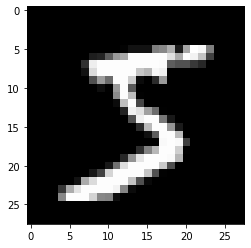

In [7]:
# MNISTのデータの1つ目を可視化する

# 2019年1月31日訂正
# %matplotlibで%のあとに入っていたスペースを削除

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(X.to_numpy()[0].reshape(28, 28), cmap='gray')
print("この画像データのラベルは{:.0f}です".format(y[0]))

In [10]:
# 2. DataLoderの作成

import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# 2.1 データを訓練とテストに分割（6:1）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/7, random_state=0)

# 2.2 データをPyTorchのTensorに変換
X_train = torch.Tensor(X_train.values)
X_test = torch.Tensor(X_test.values)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# 2.3 データとラベルをセットにしたDatasetを作成
ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

# 2.4 データセットのミニバッチサイズを指定した、Dataloaderを作成
# Chainerのiterators.SerialIteratorと似ている
loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)

In [11]:
# 3. ネットワークの構築
# Keras風の書き方 

from torch import nn

model = nn.Sequential()
model.add_module('fc1', nn.Linear(28*28*1, 100))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(100, 100))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(100, 10))

print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [12]:
# 4. 誤差関数と最適化手法の設定
 
from torch import optim
 
# 誤差関数の設定
loss_fn = nn.CrossEntropyLoss()  # 変数名にはcriterionも使われる
 
# 重みを学習する際の最適化手法の選択
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [13]:

# 5. 学習と推論の設定
# 5-1. 学習1回でやることを定義します
# Chainerのtraining.Trainer()に対応するものはない
 
from torch.autograd import Variable
 
 
def train(epoch):
    model.train()  # ネットワークを学習モードに切り替える
 
    # データローダーから1ミニバッチずつ取り出して計算する
    for data, target in loader_train:
        data, target = Variable(data), Variable(target)  # 微分可能に変換
        optimizer.zero_grad()  # 一度計算された勾配結果を0にリセット
 
        output = model(data)  # 入力dataをinputし、出力を求める
        loss = loss_fn(output, target)  # 出力と訓練データの正解との誤差を求める
        loss.backward()  # 誤差のバックプロパゲーションを求める
        optimizer.step()  # バックプロパゲーションの値で重みを更新する
 
    print("epoch{}：終了\n".format(epoch))

In [14]:
# 5. 学習と推論の設定
# 5-2. 推論1回でやることを定義します
# Chainerのtrainer.extend(extensions.Evaluator())に対応するものはない
 
 
def test():
    model.eval()  # ネットワークを推論モードに切り替える
    correct = 0
 
    # データローダーから1ミニバッチずつ取り出して計算する
    for data, target in loader_test:
        data, target = Variable(data), Variable(target)  # 微分可能に変換
        output = model(data)  # 入力dataをinputし、出力を求める
 
        # 推論する
        pred = output.data.max(1, keepdim=True)[1]  # 出力ラベルを求める
        correct += pred.eq(target.data.view_as(pred)).sum()  # 正解と一緒だったらカウントアップ
 
    # 正解率を出力
    data_num = len(loader_test.dataset)  # データの総数
    print('\nテストデータの正解率: {}/{} ({:.0f}%)\n'.format(correct,
                                                   data_num, 100. * correct / data_num))


In [15]:
# 学習なしにテストデータで推論してみよう
test()


テストデータの正解率: 1336/10000 (13%)



In [16]:

# 6. 学習と推論の実行
for epoch in range(3):
    train(epoch)

test()

epoch0：終了

epoch1：終了

epoch2：終了


テストデータの正解率: 9582/10000 (96%)



予測結果は2
この画像データの正解ラベルは2です


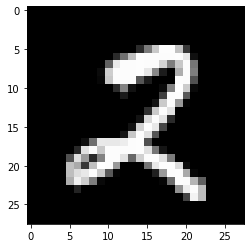

In [17]:
# 例えば2018番目の画像データを推論してみる

index = 2018

model.eval()  # ネットワークを推論モードに切り替える
data = X_test[index]
output = model(data)  # 入力dataをinputし、出力を求める
_, predicted = torch.max(output.data, 0)  # 確率が最大のラベルを求める

print("予測結果は{}".format(predicted))

X_test_show = (X_test[index]).numpy()
plt.imshow(X_test_show.reshape(28, 28), cmap='gray')
print("この画像データの正解ラベルは{:.0f}です".format(y_test[index]))

In [18]:
# 3. ネットワークの構築
# ニューラルネットワークの設定（Chainer風の書き方）
import torch.nn as nn
import torch.nn.functional as F
 
 
class Net(nn.Module):
 
    def __init__(self, n_in, n_mid, n_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, n_mid)  # Chainerと異なり、Noneは受けつけない。
        self.fc2 = nn.Linear(n_mid, n_mid)
        self.fc3 = nn.Linear(n_mid, n_out)
 
    def forward(self, x):
        # 入力xに合わせてforwardの計算を変えられる＝Define by Run
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        output = self.fc3(h2)
        return output
 
 
model = Net(n_in=28*28, n_mid=100, n_out=10)  # ネットワークのオブジェクトを生成
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
